In [2161]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.preprocessing import StandardScaler


In [2162]:

# from google.colab import drive

# drive.mount('/content/drive')


# # Load the dataset
# df = pd.read_csv('/content/drive/MyDrive/train.csv')

# Load the dataset
file_path = "train.csv"  # Ensure the file is in your working directory
df = pd.read_csv(file_path)

# Display basic info
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# <span style="color:white">Data preprocessing :Visualizing, handling missing data</span>


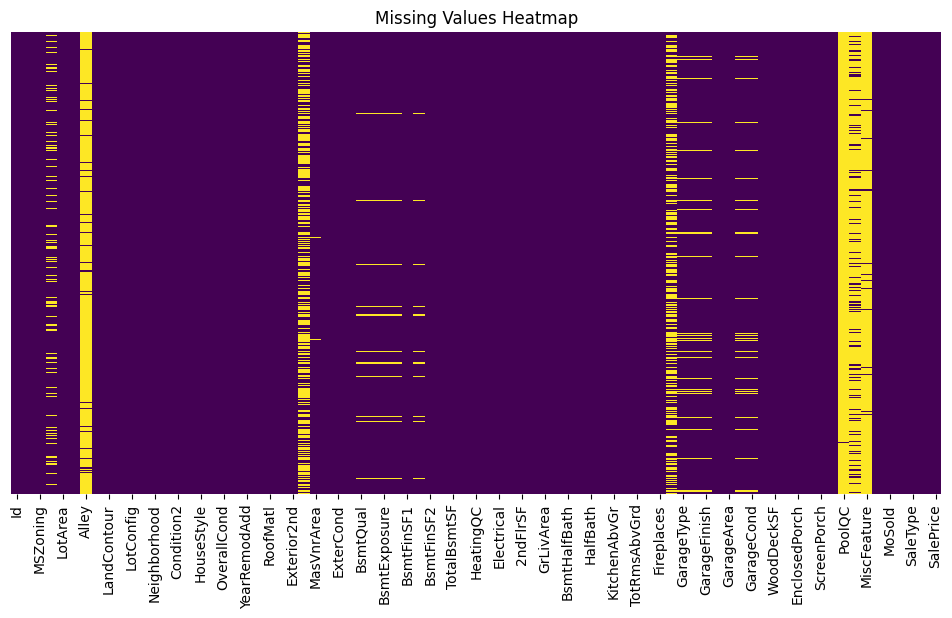

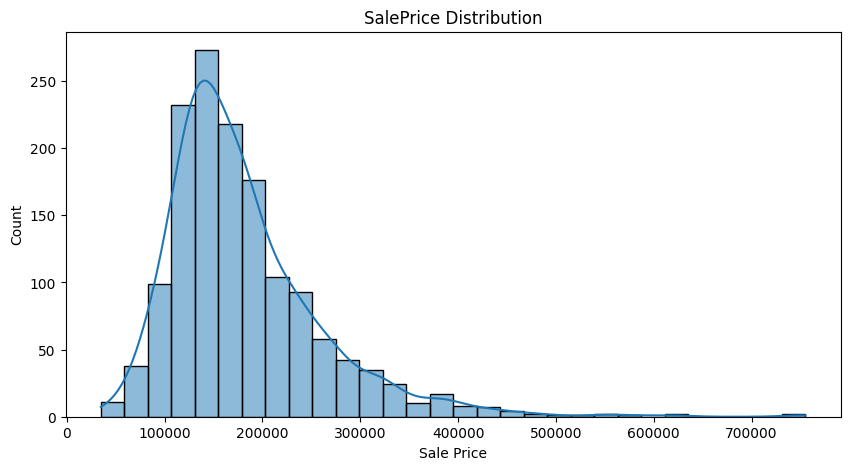

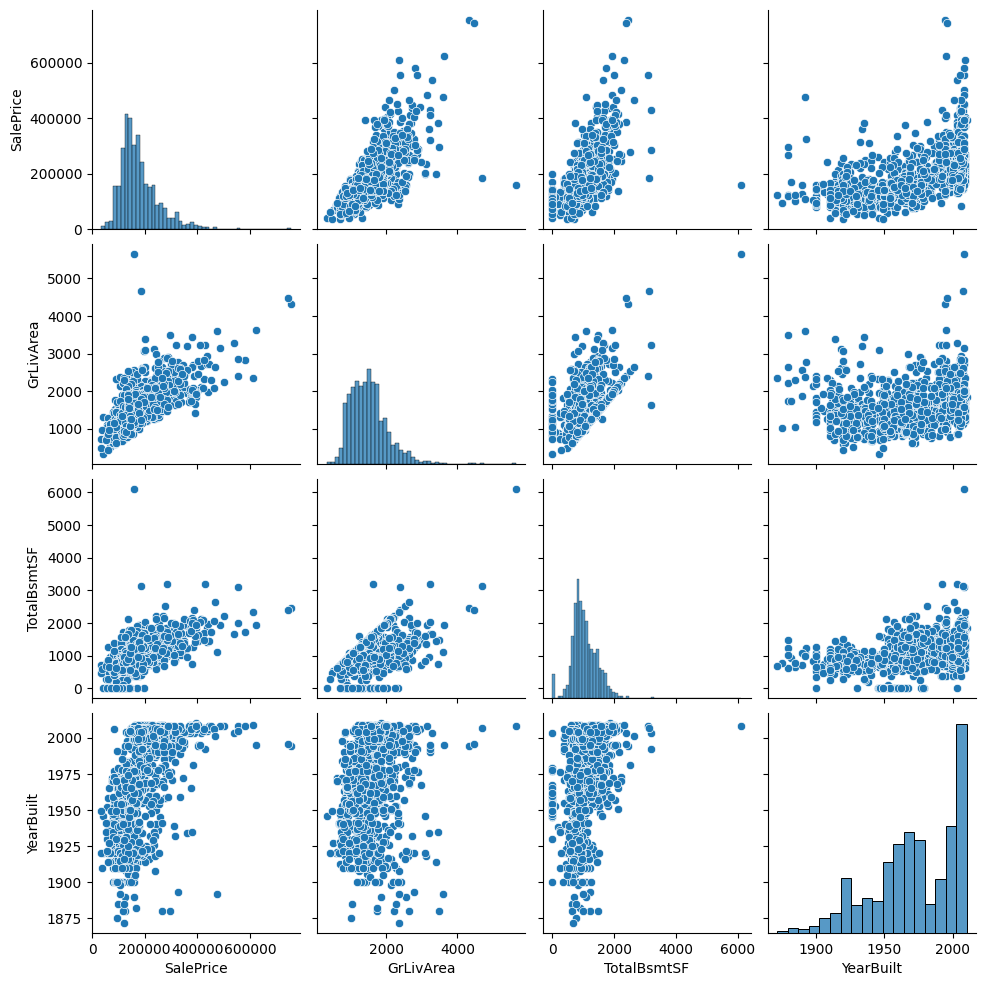

In [2163]:

# Visualizing missing values
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()

# Distribution of target variable (SalePrice)
plt.figure(figsize=(10, 5))
sns.histplot(df['SalePrice'], bins=30, kde=True)
plt.title("SalePrice Distribution")
plt.xlabel("Sale Price")
plt.ylabel("Count")
plt.show()

# Pairplot of selected numerical features (including SalePrice)
selected_features = ["SalePrice", "GrLivArea", "TotalBsmtSF", "YearBuilt"]
sns.pairplot(df[selected_features])
plt.show()


Missing Values (%):
PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
MasVnrType      59.726027
FireplaceQu     47.260274
LotFrontage     17.739726
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtQual         2.534247
BsmtCond         2.534247
BsmtFinType1     2.534247
MasVnrArea       0.547945
Electrical       0.068493
dtype: float64


C:\Users\HP\AppData\Local\Temp\ipykernel_25704\2255362329.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_data.index, y=missing_data.values, palette="viridis")


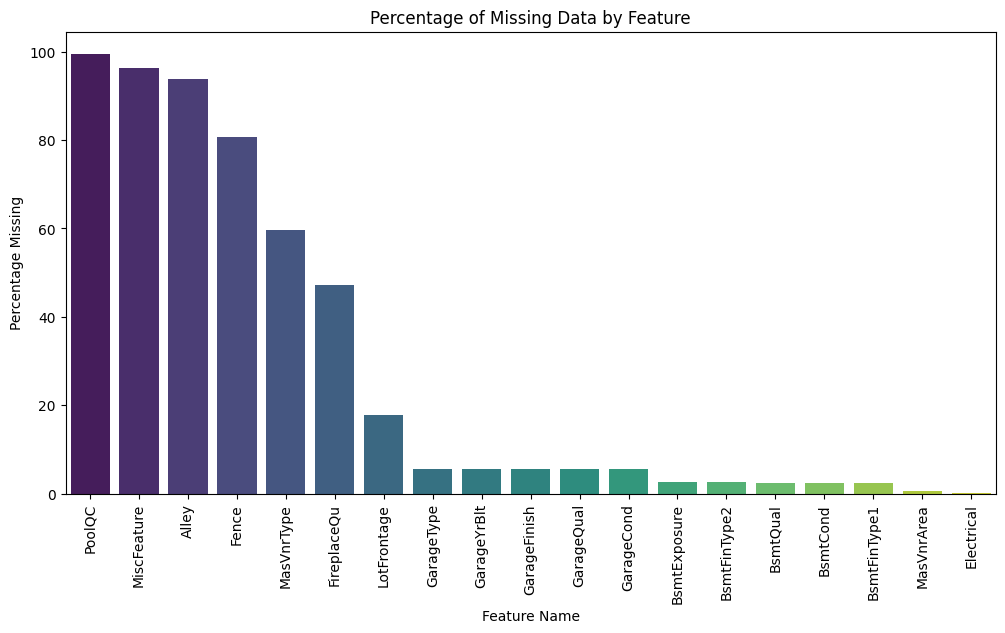

In [2164]:
# Check missing values percentage
missing_data = df.isnull().sum() / len(df) * 100

# Filter only columns with missing values
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)

# Display missing values
print("Missing Values (%):")
print(missing_data)

# Bar Chart of Missing Values
plt.figure(figsize=(12, 6))
sns.barplot(x=missing_data.index, y=missing_data.values, palette="viridis")
plt.xticks(rotation=90)
plt.xlabel("Feature Name")
plt.ylabel("Percentage Missing")
plt.title("Percentage of Missing Data by Feature")
plt.show()


REMOVING MISSING VALUES 

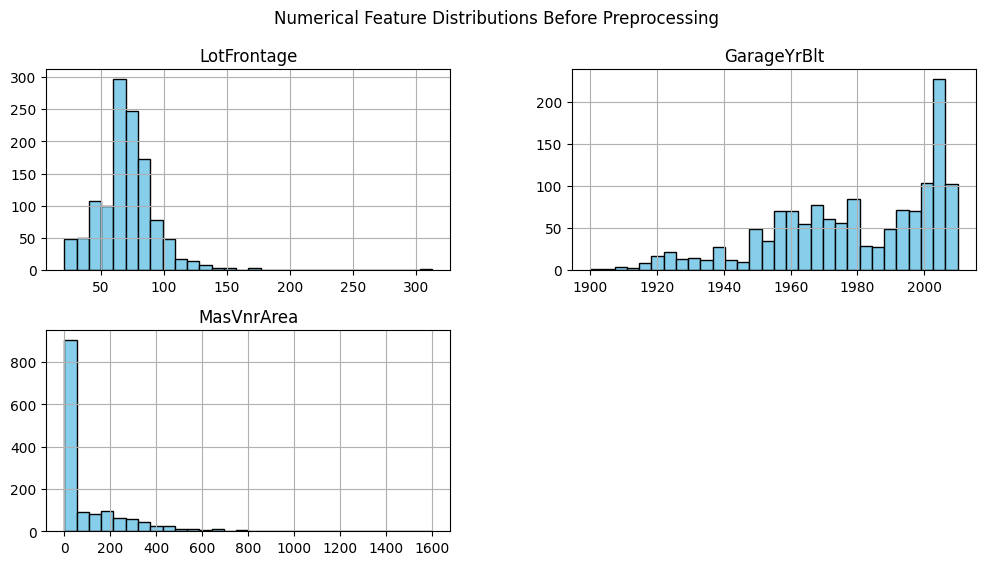

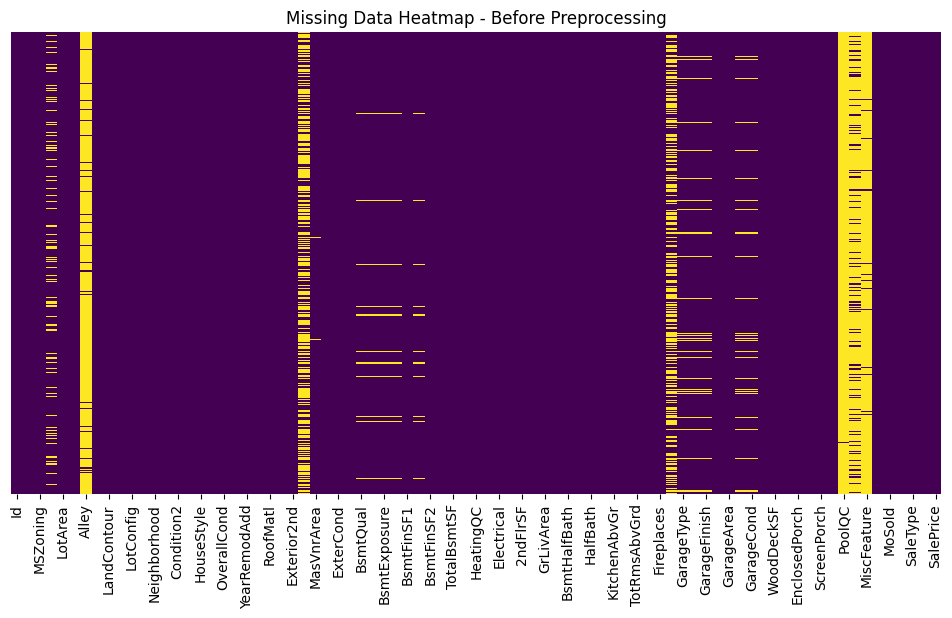

C:\Users\HP\AppData\Local\Temp\ipykernel_25704\3629190734.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna("None", inplace=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_25704\3629190734.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing

Total missing values after imputation: 0


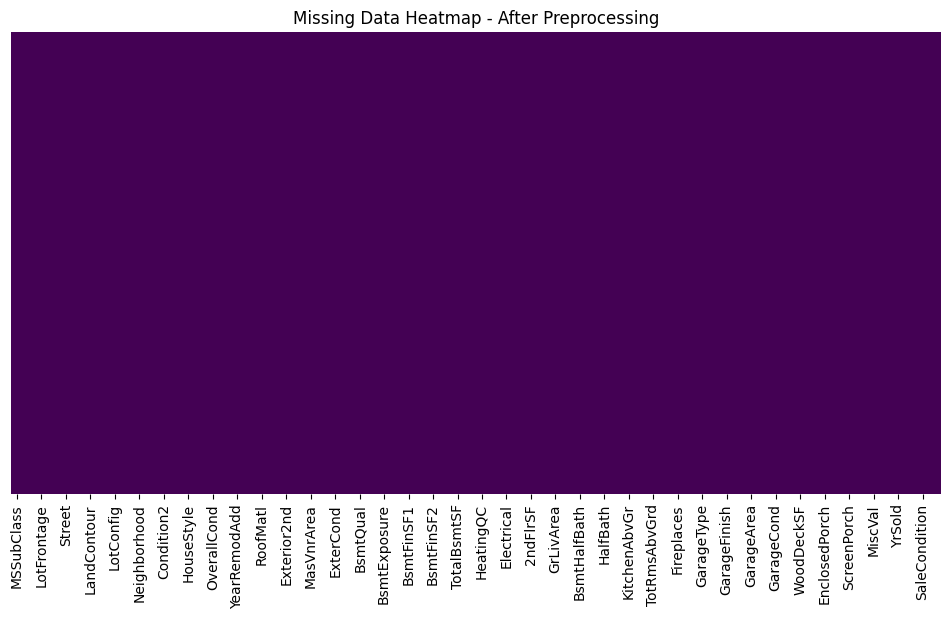

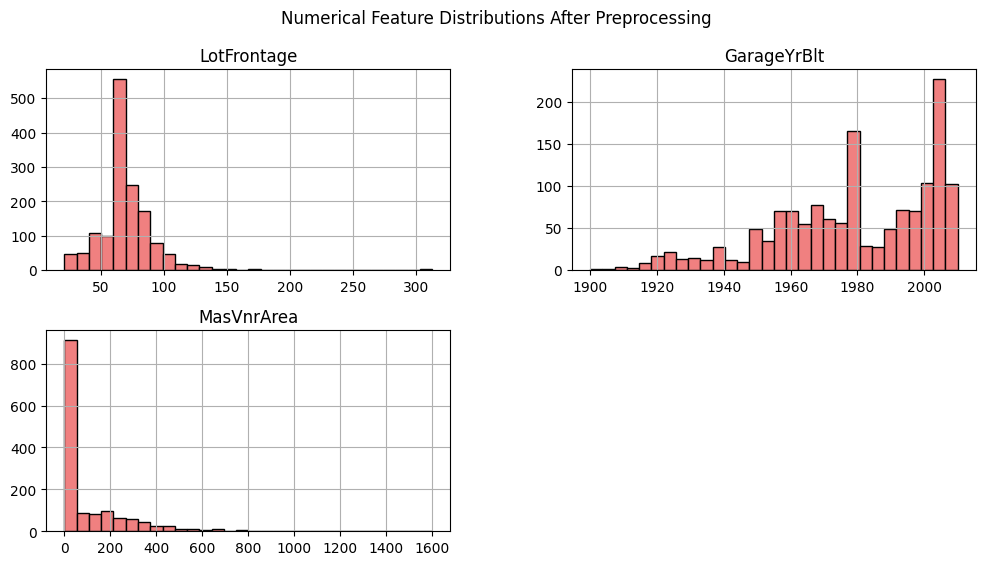

<Figure size 1200x600 with 0 Axes>

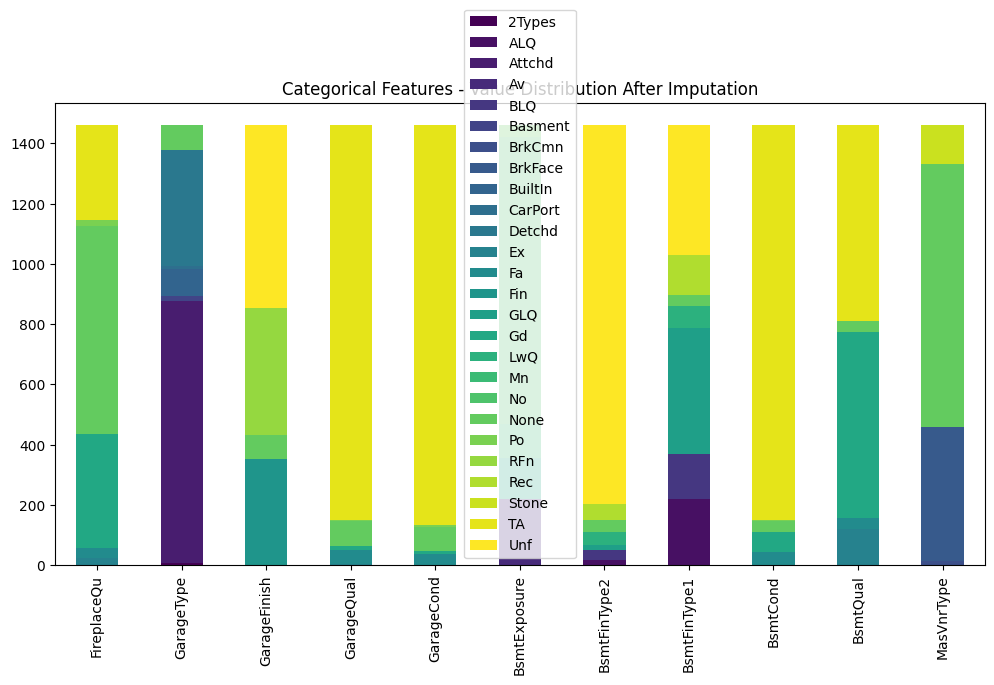

Dataset size after handling missing values: (1460, 76)


In [2165]:
def handleMissing(file_path):
    # Load the dataset
    df = pd.read_csv(file_path)
    
    # Define columns
    numerical_cols = ["LotFrontage", "GarageYrBlt", "MasVnrArea"]
    columns_to_drop = ["PoolQC", "MiscFeature", "Alley", "Fence", "Id"]
    categorical_cols = ["FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond",
                        "BsmtExposure", "BsmtFinType2", "BsmtFinType1", "BsmtCond", "BsmtQual", "MasVnrType"]
    
    # 🔹 Histogram of numerical features before preprocessing
    df[numerical_cols].hist(figsize=(12, 6), bins=30, color='skyblue', edgecolor='black')
    plt.suptitle("Numerical Feature Distributions Before Preprocessing")
    plt.show()
    
    # 🔹 Visualizing missing data before preprocessing
    plt.figure(figsize=(12, 6))
    sns.heatmap(df.isnull(), cmap='viridis', cbar=False, yticklabels=False)
    plt.title("Missing Data Heatmap - Before Preprocessing")
    plt.show()
    
    # Drop columns
    df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)
    
    # Fill categorical missing values with "None"
    for col in categorical_cols:
        if col in df.columns:
            df[col].fillna("None", inplace=True)
    
    # Fill numerical missing values with median
    for col in numerical_cols:
        if col in df.columns:
            df[col].fillna(df[col].median(), inplace=True)
    
    # Fill Electrical with most frequent value
    if "Electrical" in df.columns:
        df["Electrical"].fillna(df["Electrical"].mode()[0], inplace=True)
    
    # Save processed data back to the same file
    df.to_csv(file_path, index=False)
    
    # Verify no missing values remain
    print(f"Total missing values after imputation: {df.isnull().sum().sum()}")
    
    # 🔹 Visualizing missing data after preprocessing
    plt.figure(figsize=(12, 6))
    sns.heatmap(df.isnull(), cmap='viridis', cbar=False, yticklabels=False)
    plt.title("Missing Data Heatmap - After Preprocessing")
    plt.show()
    
    # 🔹 Histogram of numerical features after preprocessing
    df[numerical_cols].hist(figsize=(12, 6), bins=30, color='lightcoral', edgecolor='black')
    plt.suptitle("Numerical Feature Distributions After Preprocessing")
    plt.show()
    
    # 🔹 Bar Chart for Categorical Features After Imputation
    plt.figure(figsize=(12, 6))
    df[categorical_cols].apply(lambda x: x.value_counts()).T.plot(kind="bar", stacked=True, figsize=(12,6), colormap="viridis")
    plt.title("Categorical Features - Value Distribution After Imputation")
    plt.xticks(rotation=90)
    plt.show()
    print(f"Dataset size after handling missing values: {df.shape}")


handleMissing("train.csv")

Outliers

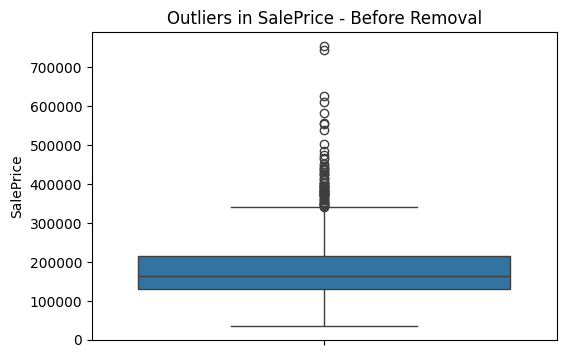

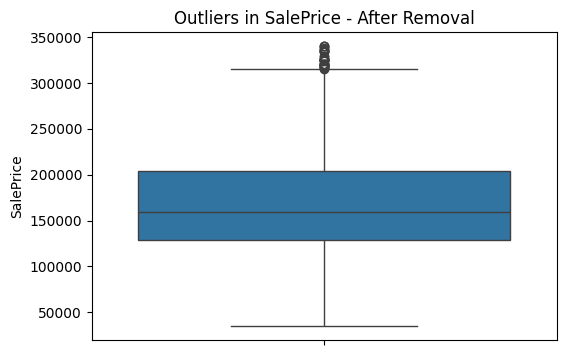

Dataset size after outlier removal: (1399, 76)


In [2166]:

def removeOutliers(file_path):
    # Load the dataset
    df = pd.read_csv(file_path)
    
    # Check if 'SalePrice' column exists
    if "SalePrice" not in df.columns:
        print("'SalePrice' column not found in the dataset.")
        return
    
    # 🔹 Boxplot before removing outliers
    plt.figure(figsize=(6, 4))
    sns.boxplot(y=df["SalePrice"])
    plt.title("Outliers in SalePrice - Before Removal")
    plt.show()
    
    # Calculate IQR and filter out outliers
    Q1 = df["SalePrice"].quantile(0.25)
    Q3 = df["SalePrice"].quantile(0.75)
    IQR = Q3 - Q1
    df = df[(df["SalePrice"] >= Q1 - 1.5 * IQR) & (df["SalePrice"] <= Q3 + 1.5 * IQR)]
    
    # Save cleaned data back to the same file
    df.to_csv(file_path, index=False)
    
    # 🔹 Boxplot after removing outliers
    plt.figure(figsize=(6, 4))
    sns.boxplot(y=df["SalePrice"])
    plt.title("Outliers in SalePrice - After Removal")
    plt.show()
    
    print(f"Dataset size after outlier removal: {df.shape}")

removeOutliers("train.csv")


# <span style="color:white">Features Engineering :encoding</span>


In [2167]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

def encode_and_standardize(file_path):
    # Load the dataset
    df = pd.read_csv(file_path)

    # List of categorical features from the dataset
    categorical_features = [
        'MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
        'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
        'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
        'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
        'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
        'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
        'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
        'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 
        'SaleType', 'SaleCondition'
    ]

    # 🔹 Define ordinal features with meaningful order
    ordinal_features = {
        "ExterQual": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "None": 0},
        "ExterCond": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "None": 0},
        "BsmtQual": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "None": 0},
        "BsmtCond": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "None": 0},
        "BsmtExposure": {"Gd": 4, "Av": 3, "Mn": 2, "No": 1, "None": 0},
        "BsmtFinType1": {"GLQ": 6, "ALQ": 5, "BLQ": 4, "Rec": 3, "LwQ": 2, "Unf": 1, "None": 0},
        "BsmtFinType2": {"GLQ": 6, "ALQ": 5, "BLQ": 4, "Rec": 3, "LwQ": 2, "Unf": 1, "None": 0},
        "HeatingQC": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "None": 0},
        "KitchenQual": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "None": 0},
        "FireplaceQu": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "None": 0},
        "GarageFinish": {"Fin": 3, "RFn": 2, "Unf": 1, "None": 0},
        "GarageQual": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "None": 0},
        "GarageCond": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "None": 0},
        "PoolQC": {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "None": 0},
        "Fence": {"GdPrv": 4, "MnPrv": 3, "GdWo": 2, "MnWw": 1, "None": 0}
    }

    # Apply ordinal encoding
    for col, mapping in ordinal_features.items():
        if col in df.columns:
            df[col] = df[col].fillna("None").map(mapping)

    # Identify nominal categorical features (unordered)
    ordinal_keys = set(ordinal_features.keys())
    nominal_features = [col for col in categorical_features if col not in ordinal_keys]

    # One-Hot Encoding for Nominal Features
    df = pd.get_dummies(df, columns=nominal_features, drop_first=True)

    print("Encoding complete. Data shape:", df.shape)

    # 🔹 Standardize Ordinal Encoded Features for Regression
    scaler = StandardScaler()
    standardize_cols = list(ordinal_keys.intersection(df.columns))  # Ensure columns exist

    df[standardize_cols] = scaler.fit_transform(df[standardize_cols])

    print("Standardization complete.")

    # Save processed data back to the same file
    df.to_csv(file_path, index=False)
    print("Processed data saved to:", file_path)

# Run the function
encode_and_standardize("train.csv")



Encoding complete. Data shape: (1399, 202)
Standardization complete.
Processed data saved to: train.csv


# <span style="color:white">Features Engineering : scaling</span>


<Figure size 1500x1000 with 0 Axes>

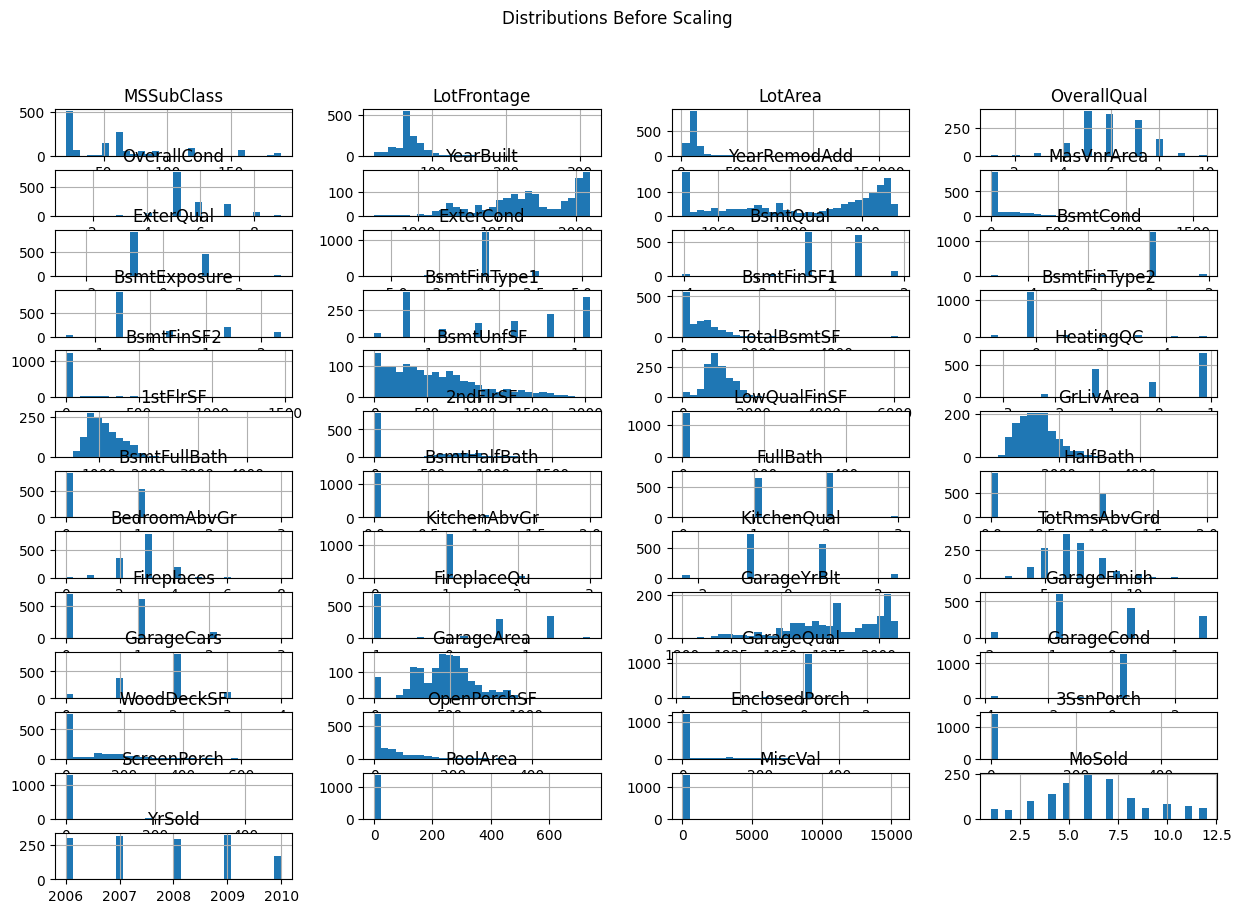

<Figure size 1500x1000 with 0 Axes>

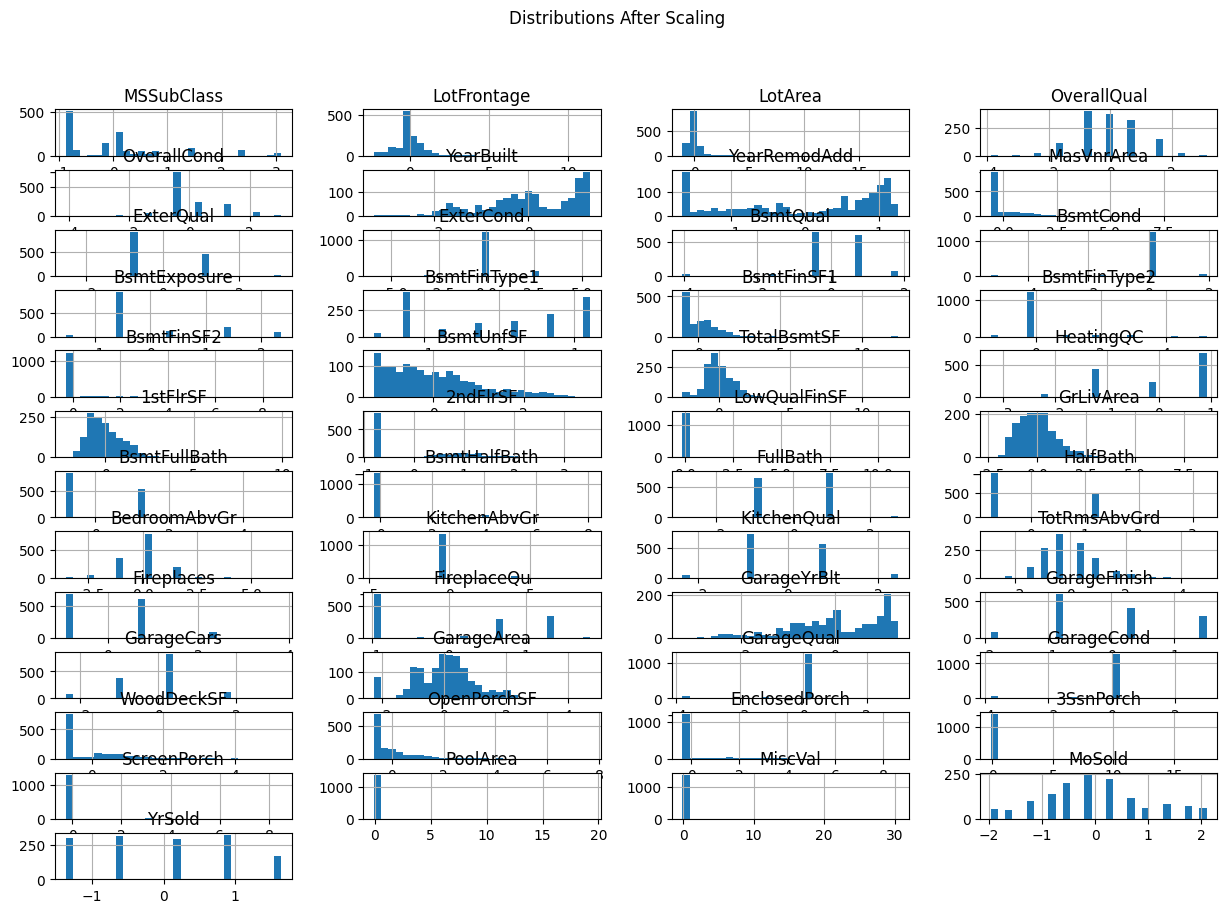

Scaling complete. Data saved to file.


In [2168]:

def scale_numerical_features(file_path, target_variable="SalePrice"):
    # Load the dataset
    df = pd.read_csv(file_path)

    # 🔹 Identify numerical features (excluding the target variable)
    numerical_features = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
    
    if target_variable in numerical_features:
        numerical_features.remove(target_variable)

    # 🔹 Function to create histograms in multiple figures
    def plot_histograms(df, features, title):
        num_features = len(features)
        cols = 4  # Number of columns in the grid
        rows = (num_features // cols) + 1  # Calculate the required rows

        for i in range(0, num_features, cols * rows):
            plt.figure(figsize=(15, 10))
            sub_features = features[i : i + (cols * rows)]  # Batch the features
            df[sub_features].hist(bins=30, figsize=(15, 10), layout=(rows, cols))
            plt.suptitle(title)
            plt.show()

    # 🔹 Visualizing distributions before scaling
    plot_histograms(df, numerical_features, "Distributions Before Scaling")

    # 🔹 Apply Standard Scaling (Z-score Normalization)
    scaler = StandardScaler()
    df[numerical_features] = scaler.fit_transform(df[numerical_features])

    # 🔹 Visualizing distributions after scaling
    plot_histograms(df, numerical_features, "Distributions After Scaling")

    # Save processed data back to the same file
    df.to_csv(file_path, index=False)

    print("Scaling complete. Data saved to file.")


scale_numerical_features("train.csv")

# <span style="color:white">Features Engineering :selection</span>


In [2169]:


def select_important_features(file_path, target_variable="SalePrice", correlation_threshold=0.4, vif_threshold=10):
    # Load the dataset
    df = pd.read_csv(file_path)

    # Check if the dataset contains "SalePrice" (i.e., training dataset)
    if target_variable in df.columns:
        # 🔹 Compute correlation with target variable
        correlation = df.corr()[target_variable].abs().sort_values(ascending=False)

        # 🔹 Select features with correlation above the threshold
        selected_features = correlation[correlation > correlation_threshold].index.tolist()

        # Remove the target variable from selected features (to avoid self-correlation)
        if target_variable in selected_features:
            selected_features.remove(target_variable)

        print(f"📌 Selected {len(selected_features)} features based on correlation > {correlation_threshold}")

        # If no features are selected, return early
        if not selected_features:
            print("❌ No features met the correlation threshold. Exiting...")
            return

        # 🔹 Ensure all selected features are numeric
        df[selected_features] = df[selected_features].apply(pd.to_numeric, errors="coerce")

        # 🔹 Handle NaN and infinite values
        df[selected_features] = df[selected_features].replace([np.inf, -np.inf], np.nan)
        df = df.dropna()  # Drop rows with missing values

        print(f"✅ Remaining data shape after removing NaNs: {df.shape}")

        # If no valid rows remain, return early
        if df.empty:
            print("❌ No data left after dropping NaNs. Exiting...")
            return

        # 🔹 Function to calculate VIF
        def calculate_vif(df, features):
            if len(features) < 2:
                print("⚠️ Not enough features for VIF calculation. Skipping...")
                return pd.DataFrame(columns=["Feature", "VIF"])

            vif_data = pd.DataFrame()
            vif_data["Feature"] = features
            vif_data["VIF"] = [variance_inflation_factor(df[features].values.astype(float), i) for i in range(len(features))]
            return vif_data

        # Compute VIF
        vif_df = calculate_vif(df, selected_features)

        # If VIF calculation failed, return early
        if vif_df.empty:
            print("❌ VIF calculation failed due to insufficient features. Exiting...")
            return

        # 🔹 Drop features with high VIF
        low_vif_features = vif_df[vif_df["VIF"] < vif_threshold]["Feature"].tolist()
        df = df[low_vif_features + [target_variable]]  # Keep target variable for training

        print(f"✅ Selected {len(low_vif_features)} features after VIF filtering")

        # If no features remain after VIF filtering, return early
        if not low_vif_features:
            print("❌ All features removed due to high VIF. Exiting...")
            return

        # 🔹 Save selected features to a file (for future prediction use)
        with open("selected_features.txt", "w") as f:
            f.write("\n".join(low_vif_features))

    else:
        # If "SalePrice" is missing (for prediction data)
        try:
            with open("selected_features.txt", "r") as f:
                low_vif_features = f.read().splitlines()
            df = df[low_vif_features]  # Use the same features as training
        except FileNotFoundError:
            print("❌ selected_features.txt not found. Train model first.")
            return

    # 🔹 Save processed data back to the file
    df.to_csv(file_path, index=False)
    print(f"✅ Feature selection complete. Remaining features: {df.columns}")

# Run feature selection on training data
select_important_features("train.csv")

# Run feature selection on prediction data


📌 Selected 20 features based on correlation > 0.4
✅ Remaining data shape after removing NaNs: (1399, 202)
✅ Selected 20 features after VIF filtering
✅ Feature selection complete. Remaining features: Index(['OverallQual', 'GrLivArea', 'ExterQual', 'KitchenQual', 'GarageCars',
       'GarageArea', 'FullBath', 'BsmtQual', 'GarageFinish', 'YearBuilt',
       'TotalBsmtSF', 'YearRemodAdd', '1stFlrSF', 'Foundation_PConc',
       'FireplaceQu', 'GarageYrBlt', 'TotRmsAbvGrd', 'Fireplaces', 'HeatingQC',
       'GarageType_Attchd', 'SalePrice'],
      dtype='object')


In [2170]:
# import pandas as pd

# def convert_strings_to_floats(file_path):
#     # Load dataset
#     df = pd.read_csv(file_path)
    
#     # Iterate through each column
#     for col in df.columns:
#         # Try converting the entire column to float
#         try:
#             df[col] = df[col].astype(float)
#         except ValueError:
#             # If conversion fails, replace categorical values with unique numerical codes
#             unique_values = df[col].unique()
#             value_map = {val: idx for idx, val in enumerate(unique_values)}
#             df[col] = df[col].map(value_map).astype(float)  # Ensure final type is float
    
#     # Save the transformed dataset
#     df.to_csv(file_path, index=False)
    
#     print(f"Conversion complete. Saved to {file_path}.")
#     return df  # Return transformed DataFrame for verification

# # Run the function
# df_converted = convert_strings_to_floats("train.csv")


In [2171]:
trainSetpreprocessed= pd.read_csv("train.csv")
trainSetpreprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1399 entries, 0 to 1398
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   OverallQual        1399 non-null   float64
 1   GrLivArea          1399 non-null   float64
 2   ExterQual          1399 non-null   float64
 3   KitchenQual        1399 non-null   float64
 4   GarageCars         1399 non-null   float64
 5   GarageArea         1399 non-null   float64
 6   FullBath           1399 non-null   float64
 7   BsmtQual           1399 non-null   float64
 8   GarageFinish       1399 non-null   float64
 9   YearBuilt          1399 non-null   float64
 10  TotalBsmtSF        1399 non-null   float64
 11  YearRemodAdd       1399 non-null   float64
 12  1stFlrSF           1399 non-null   float64
 13  Foundation_PConc   1399 non-null   bool   
 14  FireplaceQu        1399 non-null   float64
 15  GarageYrBlt        1399 non-null   float64
 16  TotRmsAbvGrd       1399 

# <span style="color:white">Splitting</span>


In [2172]:
#splitting
# Define features (X) and target variable (y)
X = trainSetpreprocessed.drop(columns=["SalePrice"])  # All columns except target
y = trainSetpreprocessed["SalePrice"]  # Target variable

# First, split into Training (70%) and Temp (30%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Split Temp into Validation (15%) and Test (15%) sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set: X={X_train.shape}, y={y_train.shape[0]}")
print(f"Validation set: X={X_val.shape}, y={y_val.shape[0]}")
print(f"Test set: X={X_test.shape}, y={y_test.shape[0]}")



Training set: X=(979, 20), y=979
Validation set: X=(210, 20), y=210
Test set: X=(210, 20), y=210


# <span style="color:yellow">⚙️Linear Regression Model</span>


In [2173]:

# Define model
model = LinearRegression()

# Define k-fold cross-validation (k=5)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and store scores
rmse_scores = []
mae_scores = []
r2_scores = []

for train_index, val_index in kf.split(X_train):
    X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]

    # Train the model
    model.fit(X_fold_train, y_fold_train)

    # Predict on validation fold
    y_pred = model.predict(X_fold_val)

    # Compute metrics
    rmse_scores.append(np.sqrt(mean_squared_error(y_fold_val, y_pred)))
    mae_scores.append(mean_absolute_error(y_fold_val, y_pred))
    r2_scores.append(r2_score(y_fold_val, y_pred))

# Print average scores
print(f"Average RMSE: {np.mean(rmse_scores):.4f}")
print(f"Average MAE: {np.mean(mae_scores):.4f}")
print(f"Average R² Score: {np.mean(r2_scores):.4f}")



Average RMSE: 29013.9646
Average MAE: 19708.4429
Average R² Score: 0.7619


In [2174]:
# Train model on full training set
model.fit(X_train, y_train)

# Predict on test set
y_test_pred = model.predict(X_test)

# Compute test set metrics
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("\nFinal Model Performance on Test Set:")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R² Score: {test_r2:.4f}")

#  Save the trained model
joblib.dump(model, "linearRegression.pkl")
print("✅ Model saved as 'linearRegression.pkl'")


Final Model Performance on Test Set:
Test RMSE: 23845.0511
Test MAE: 18832.8486
Test R² Score: 0.8057
✅ Model saved as 'linearRegression.pkl'


# <span style="color:cyan"> 📈Learning Curve Visualization</span>


   #### Interpretation:
- X-axis (train_sizes) → Number of training examples used.
- Y-axis (MSE) → Error on both training and validation sets.
- Blue Line (Training Loss) → How well the model fits the training data.
- Orange Dashed Line (Validation Loss) → How well the model generalizes to unseen data.

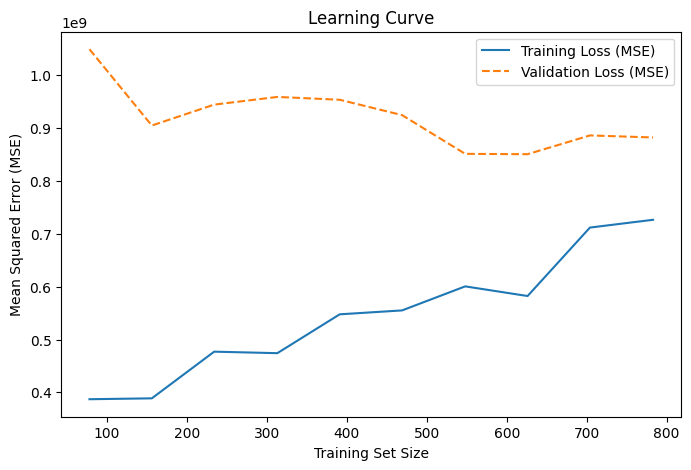

In [2175]:
from sklearn.model_selection import learning_curve

# Get learning curve
train_sizes, train_scores, val_scores = learning_curve(
    model, X_train, y_train, cv=5, scoring="neg_mean_squared_error", train_sizes=np.linspace(0.1, 1.0, 10)
)

# Compute mean loss
train_mean = -np.mean(train_scores, axis=1)
val_mean = -np.mean(val_scores, axis=1)

# Plot Learning Curve
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, label="Training Loss (MSE)")
plt.plot(train_sizes, val_mean, label="Validation Loss (MSE)", linestyle="dashed")
plt.xlabel("Training Set Size")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Learning Curve")
plt.legend()
plt.show()


# Gradient descent

#### Interpretation:
- X-axis (train_sizes) → Number of training examples used.
- Y-axis (MSE) → Error on both training and validation sets.
- Blue Line (Training Loss) → How well the model fits the training data.
- Orange Dashed Line (Validation Loss) → How well the model generalizes to unseen data.

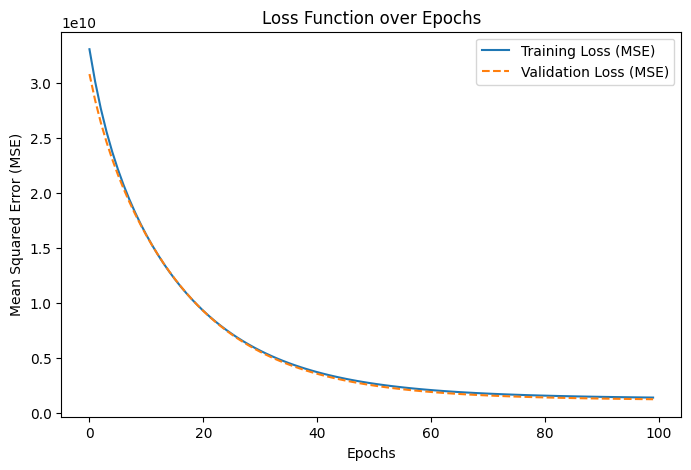

In [2176]:
import numpy as np
import matplotlib.pyplot as plt
# Convert DataFrame values to numeric
X_train = X_train.astype(float)
y_train = y_train.astype(float)
X_val = X_val.astype(float)
y_val = y_val.astype(float)

# Initialize parameters
def initialize_weights(n_features):
    w = np.zeros(n_features)  # Weights
    b = 0  # Bias
    return w, b

# Compute MSE Loss
def compute_mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Gradient Descent Implementation
def train_linear_regression(X_train, y_train, X_val, y_val, learning_rate=0.01, epochs=100):
    n_samples, n_features = X_train.shape
    w, b = initialize_weights(n_features)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Compute Predictions
        y_train_pred = np.dot(X_train, w) + b
        y_val_pred = np.dot(X_val, w) + b

        # Compute Loss
        train_loss = compute_mse(y_train, y_train_pred)
        val_loss = compute_mse(y_val, y_val_pred)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Compute Gradients
        dw = -(2 / n_samples) * np.dot(X_train.T, (y_train - y_train_pred))
        db = -(2 / n_samples) * np.sum(y_train - y_train_pred)

        # Update Weights
        w -= learning_rate * dw
        b -= learning_rate * db

    return train_losses, val_losses

# Train the model using gradient descent
train_losses, val_losses = train_linear_regression(X_train.values, y_train.values, X_val.values, y_val.values)

# Plot Training and Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(range(len(train_losses)), train_losses, label="Training Loss (MSE)")
plt.plot(range(len(val_losses)), val_losses, label="Validation Loss (MSE)", linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Loss Function over Epochs")
plt.legend()
plt.show()


 #### Interpretation:
- X-axis (Actual Prices) → The true housing prices from the test set.
- Y-axis (Predicted Prices) → The prices predicted by the linear regression model.
- Blue Dots → Individual predictions, comparing actual vs. predicted values.
- Red Dashed Line → Ideal perfect prediction line (where actual = predicted).

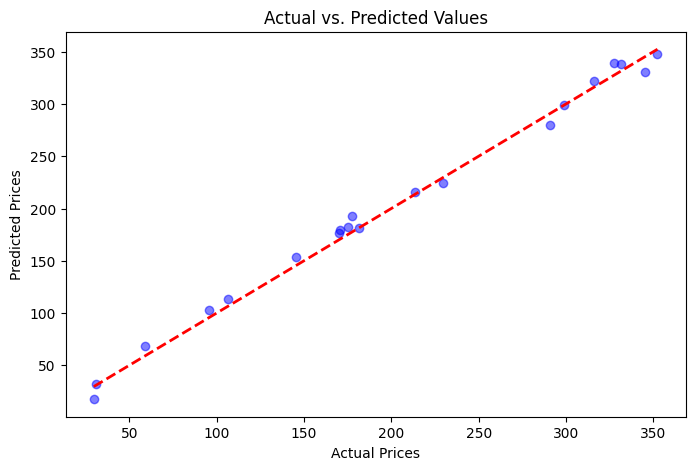

In [2177]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Sample Data (Ensure X and y are properly defined)
X = np.random.rand(100, 1) * 100  # 100 random values
y = 3.5 * X.squeeze() + np.random.randn(100) * 10  # Linear relationship with noise

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Model
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Ensure `y_test` and `y_pred` are the same length
if len(y_test) != len(y_pred):
    y_test = y_test[:len(y_pred)]  # Adjust if necessary

# Plot Actual vs Predicted Values
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.5, color="blue")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle="--", linewidth=2)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs. Predicted Values")
plt.show()



## Residuals Histogram

#### Interpretation: 
- X-axis (Residuals) → The difference between actual and predicted values (y_test - y_pred).
- Y-axis (Frequency) → The number of occurrences of each residual value.
- Bars → Show how the residuals are distributed across different error values.
- Red Dashed Line at Zero → Ideal scenario where predicted values perfectly match actual values.

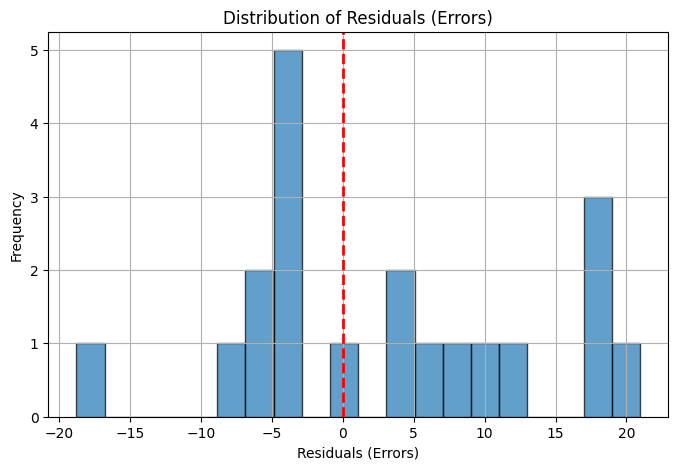

In [2178]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Sample Data (Ensure X and y are properly defined)
X = np.random.rand(100, 1) * 100  # 100 random values
y = 3.5 * X.squeeze() + np.random.randn(100) * 10  # Linear relationship with noise

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Model
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Compute Residuals
residuals = y_test - y_pred  # Difference between actual and predicted values

# Plot Residuals Histogram
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=20, edgecolor='black', alpha=0.7)
plt.axvline(0, color='red', linestyle="--", linewidth=2)  # Reference line at zero
plt.xlabel("Residuals (Errors)")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals (Errors)")
plt.grid(True)
plt.show()


# <span style="color:yellow">⚙️ Polynomial Regression Model</span>


Best polynomial degree: 2
Best parameters: {'polynomialfeatures__degree': 2, 'polynomialfeatures__include_bias': True}

Test Set Performance:
RMSE: 3.987
R² Score: 0.998


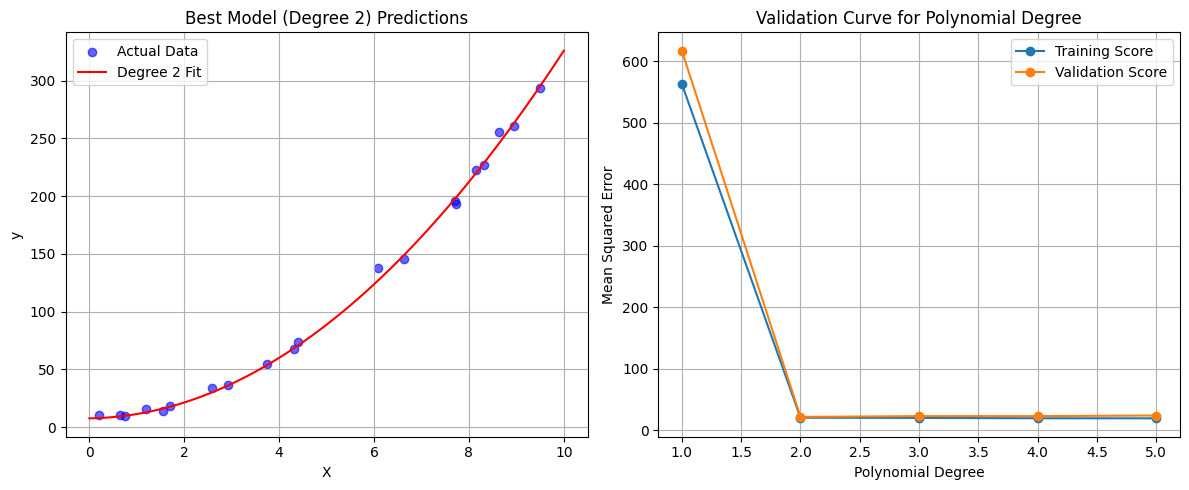


Cross-validation results:


,param_polynomialfeatures__degree,param_polynomialfeatures__include_bias,mean_test_score,mean_train_score
0,1,True,-616.809677,-562.629760
1,1,False,-616.809677,-562.629760
2,2,True,-21.547460,-20.243231
3,2,False,-21.547460,-20.243231
4,3,True,-22.838117,-19.919649
5,3,False,-22.838117,-19.919649
6,4,True,-22.872898,-19.374730
7,4,False,-22.872898,-19.374730
8,5,True,-23.839648,-19.233563
9,5,False,-23.839648,-19.233563


✅ Model saved as 'Polynomial_Regression_model.pkl'


In [2179]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Generate Non-Linear Data
np.random.seed(42)
X = np.random.rand(100, 1) * 10
y = 3 * (X**2) + 2 * X + 5 + np.random.randn(100, 1) * 5

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create pipeline with hyperparameter tuning
poly_pipe = make_pipeline(
    PolynomialFeatures(),
    LinearRegression()
)

# Define parameter grid for tuning
param_grid = {
    'polynomialfeatures__degree': range(1, 6),  # Test degrees 1-5
    'polynomialfeatures__include_bias': [True, False]  # Test bias term inclusion
}

# Set up grid search with cross-validation
grid_search = GridSearchCV(poly_pipe, param_grid, cv=5,
                          scoring='neg_mean_squared_error',
                          return_train_score=True)

# Perform hyperparameter tuning
grid_search.fit(X_train, y_train)

# Get best model and parameters
best_degree = grid_search.best_params_['polynomialfeatures__degree']
best_model = grid_search.best_estimator_
print(f"Best polynomial degree: {best_degree}")
print(f"Best parameters: {grid_search.best_params_}")

# Evaluate on test set
y_pred = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_r2 = r2_score(y_test, y_pred)

print("\nTest Set Performance:")
print(f"RMSE: {test_rmse:.3f}")
print(f"R² Score: {test_r2:.3f}")

# Plot results
plt.figure(figsize=(12, 5))

# Plot actual vs predicted
plt.subplot(1, 2, 1)
x_plot = np.linspace(0, 10, 100).reshape(-1, 1)
y_plot = best_model.predict(x_plot)
plt.scatter(X_test, y_test, color="blue", label="Actual Data", alpha=0.6)
plt.plot(x_plot, y_plot, color="red", label=f"Degree {best_degree} Fit")
plt.xlabel("X")
plt.ylabel("y")
plt.title(f"Best Model (Degree {best_degree}) Predictions")
plt.legend()
plt.grid(True)

# Plot validation curve for degrees
plt.subplot(1, 2, 2)
degrees = param_grid['polynomialfeatures__degree']
train_scores = -grid_search.cv_results_['mean_train_score'][::2]  # Only show degree variation
test_scores = -grid_search.cv_results_['mean_test_score'][::2]

plt.plot(degrees, train_scores, 'o-', label="Training Score")
plt.plot(degrees, test_scores, 'o-', label="Validation Score")
plt.xlabel("Polynomial Degree")
plt.ylabel("Mean Squared Error")
plt.title("Validation Curve for Polynomial Degree")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Display all results
results = pd.DataFrame(grid_search.cv_results_)
print("\nCross-validation results:")
display(results[['param_polynomialfeatures__degree',
                'param_polynomialfeatures__include_bias',
                'mean_test_score',
                'mean_train_score']])

#  Save the trained model
joblib.dump(best_model, "Polynomial_Regression_model.pkl")
print("✅ Model saved as 'Polynomial_Regression_model.pkl'")

# <span style="color:cyan">📈 Learning Curves Visualization</span>


In [2180]:

# # Validation Curve for Polynomial Degree
# plt.subplot(1, 2, 2)
# degrees = param_grid['polynomialfeatures__degree']
# train_scores = -grid_search.cv_results_['mean_train_score'][::2]  # Only show degree variation
# test_scores = -grid_search.cv_results_['mean_test_score'][::2]

# plt.plot(degrees, train_scores, 'o-', label="Training Score")
# plt.plot(degrees, test_scores, 'o-', label="Validation Score")
# plt.xlabel("Polynomial Degree")
# plt.ylabel("Mean Squared Error")
# plt.title("Validation Curve for Polynomial Degree")
# plt.legend()
# plt.grid(True)

# plt.tight_layout()
# plt.show()


# <span style="color:yellow">⚙️Lasso Regression Model</span>


In [2181]:
# # ... (Previous imports remain the same)
# from sklearn.linear_model import Lasso
# from sklearn.model_selection import GridSearchCV



# # Define features (X) and target variable (y) - Same as before
# X = df.drop(columns=["SalePrice"])
# y = df["SalePrice"]

# # Train-Test Split (Same as before)
# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# # Hyperparameter Tuning with Grid Search
# lasso = Lasso(max_iter=10000)  # Increased max_iter for convergence
# parameters = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
# grid_search = GridSearchCV(lasso, parameters, cv=5, scoring='neg_mean_squared_error')
# grid_search.fit(X_train, y_train)

# # Best parameters
# best_alpha = grid_search.best_params_['alpha']
# print(f"Best alpha: {best_alpha}")

# # Train final model with best alpha
# best_lasso = Lasso(alpha=best_alpha, max_iter=10000)
# best_lasso.fit(X_train, y_train)

# # Cross-validated metrics (Same structure as before)
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# rmse_scores = []
# mae_scores = []
# r2_scores = []

# for train_index, val_index in kf.split(X_train):
#     X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
#     y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]

#     best_lasso.fit(X_fold_train, y_fold_train)
#     y_pred = best_lasso.predict(X_fold_val)

#     rmse_scores.append(np.sqrt(mean_squared_error(y_fold_val, y_pred)))
#     mae_scores.append(mean_absolute_error(y_fold_val, y_pred))
#     r2_scores.append(r2_score(y_fold_val, y_pred))

# print("\nCross-validated Metrics:")
# print(f"Average RMSE: {np.mean(rmse_scores):.4f}")
# print(f"Average MAE: {np.mean(mae_scores):.4f}")
# print(f"Average R² Score: {np.mean(r2_scores):.4f}")

# # Test Set Evaluation (Same as before)
# y_test_pred = best_lasso.predict(X_test)
# test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
# test_mae = mean_absolute_error(y_test, y_test_pred)
# test_r2 = r2_score(y_test, y_test_pred)

# print("\nTest Set Metrics:")
# print(f"RMSE: {test_rmse:.4f}")
# print(f"MAE: {test_mae:.4f}")
# print(f"R² Score: {test_r2:.4f}")

# # Learning Curve (Same structure)
# train_sizes, train_scores, val_scores = learning_curve(
#     best_lasso, X_train, y_train, cv=5, scoring="neg_mean_squared_error",
#     train_sizes=np.linspace(0.1, 1.0, 10), shuffle=True, random_state=42
# )

# plt.figure(figsize=(8, 5))
# plt.plot(train_sizes, -np.mean(train_scores, axis=1), label="Training Loss")
# plt.plot(train_sizes, -np.mean(val_scores, axis=1), label="Validation Loss", linestyle="--")
# plt.title("Lasso Regression Learning Curve")
# plt.xlabel("Training Examples")
# plt.ylabel("MSE Loss")
# plt.legend()
# plt.show()

# # Actual vs Predicted Plot (Same as before)
# plt.figure(figsize=(8, 5))
# plt.scatter(y_test, y_test_pred, alpha=0.5)
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
# plt.xlabel("Actual Prices")
# plt.ylabel("Predicted Prices")
# plt.title("Lasso: Actual vs Predicted Prices")
# plt.show()

# # Residuals Plot (Same as before)
# residuals = y_test - y_test_pred
# plt.figure(figsize=(8, 5))
# plt.scatter(y_test_pred, residuals, alpha=0.5)
# plt.axhline(0, color='r', linestyle='--')
# plt.xlabel("Predicted Values")
# plt.ylabel("Residuals")
# plt.title("Lasso: Residual Plot")
# plt.show()

# <span style="color:cyan">📈 Learning Curve Visualization</span>


# <span style="color:yellow">⚙️Ridge Regression Model</span>


In [2182]:
# from sklearn.linear_model import Ridge

# # Hyperparameter Tuning with Grid Search
# ridge = Ridge(max_iter=10000, random_state=42)
# parameters = {'alpha': np.logspace(-4, 4, 20)}
# grid_search = GridSearchCV(ridge, parameters, cv=5,
#                           scoring='neg_mean_squared_error', n_jobs=-1)
# grid_search.fit(X_train, y_train)

# # Best parameters
# best_alpha = grid_search.best_params_['alpha']
# print(f"Best alpha: {best_alpha:.4f}")

# # Train final model with best alpha
# best_ridge = Ridge(alpha=best_alpha, max_iter=10000, random_state=42)
# best_ridge.fit(X_train, y_train)

# # Cross-validated metrics (Fixed indexing)
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# ridge_rmse_scores = []
# ridge_mae_scores = []
# ridge_r2_scores = []

# for train_index, val_index in kf.split(X_train):
#     X_fold_train = X_train.iloc[train_index]  # DataFrame features
#     X_fold_val = X_train.iloc[val_index]
#     y_fold_train = y_train[train_index]  # Numpy array target
#     y_fold_val = y_train[val_index]

#     best_ridge.fit(X_fold_train, y_fold_train)
#     y_pred = best_ridge.predict(X_fold_val)

#     ridge_rmse_scores.append(np.sqrt(mean_squared_error(y_fold_val, y_pred)))
#     ridge_mae_scores.append(mean_absolute_error(y_fold_val, y_pred))
#     ridge_r2_scores.append(r2_score(y_fold_val, y_pred))

# print("\nCross-validated Metrics (Ridge):")
# print(f"Average RMSE: {np.mean(ridge_rmse_scores):.4f}")
# print(f"Average MAE: {np.mean(ridge_mae_scores):.4f}")
# print(f"Average R² Score: {np.mean(ridge_r2_scores):.4f}")

# # Test Set Evaluation
# y_test_pred_ridge = best_ridge.predict(X_test)
# test_rmse_ridge = np.sqrt(mean_squared_error(y_test, y_test_pred_ridge))
# test_mae_ridge = mean_absolute_error(y_test, y_test_pred_ridge)
# test_r2_ridge = r2_score(y_test, y_test_pred_ridge)

# print("\nTest Set Metrics (Ridge):")
# print(f"RMSE: {test_rmse_ridge:.4f}")
# print(f"MAE: {test_mae_ridge:.4f}")
# print(f"R² Score: {test_r2_ridge:.4f}")

# # Learning Curve
# train_sizes, train_scores, val_scores = learning_curve(
#     best_ridge, X_train, y_train, cv=5, scoring="neg_mean_squared_error",
#     train_sizes=np.linspace(0.1, 1.0, 10), shuffle=True, random_state=42
# )

# plt.figure(figsize=(8, 5))
# plt.plot(train_sizes, -np.mean(train_scores, axis=1), label="Training Loss")
# plt.plot(train_sizes, -np.mean(val_scores, axis=1), label="Validation Loss", linestyle="--")
# plt.title("Ridge Regression Learning Curve")
# plt.xlabel("Training Examples")
# plt.ylabel("MSE Loss")
# plt.legend()
# plt.show()

# # Actual vs Predicted Plot
# plt.figure(figsize=(8, 5))
# plt.scatter(y_test, y_test_pred_ridge, alpha=0.5, label='Predictions')
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
# plt.xlabel("Actual Prices")
# plt.ylabel("Predicted Prices")
# plt.title("Ridge: Actual vs Predicted Prices")
# plt.legend()
# plt.show()

# # Residuals Plot
# residuals_ridge = y_test - y_test_pred_ridge
# plt.figure(figsize=(8, 5))
# plt.scatter(y_test_pred_ridge, residuals_ridge, alpha=0.5)
# plt.axhline(0, color='r', linestyle='--')
# plt.xlabel("Predicted Values")
# plt.ylabel("Residuals")
# plt.title("Ridge: Residual Plot")
# plt.show()

# # Feature Importance
# coefficients = pd.Series(best_ridge.coef_, index=X_train.columns)
# important_features = coefficients.abs().sort_values(ascending=False).head(20)

# plt.figure(figsize=(10, 6))
# important_features.sort_values().plot.barh(color='skyblue')
# plt.title("Top 20 Important Features (Ridge Regression)")
# plt.xlabel("Coefficient Magnitude")
# plt.ylabel("Features")
# plt.tight_layout()
# plt.show()

# <span style="color:cyan">📈 Learning Curve Visualization</span>


# <span style="color:purple"> Predict on unseen data</span>


🔄 Starting Preprocessing...


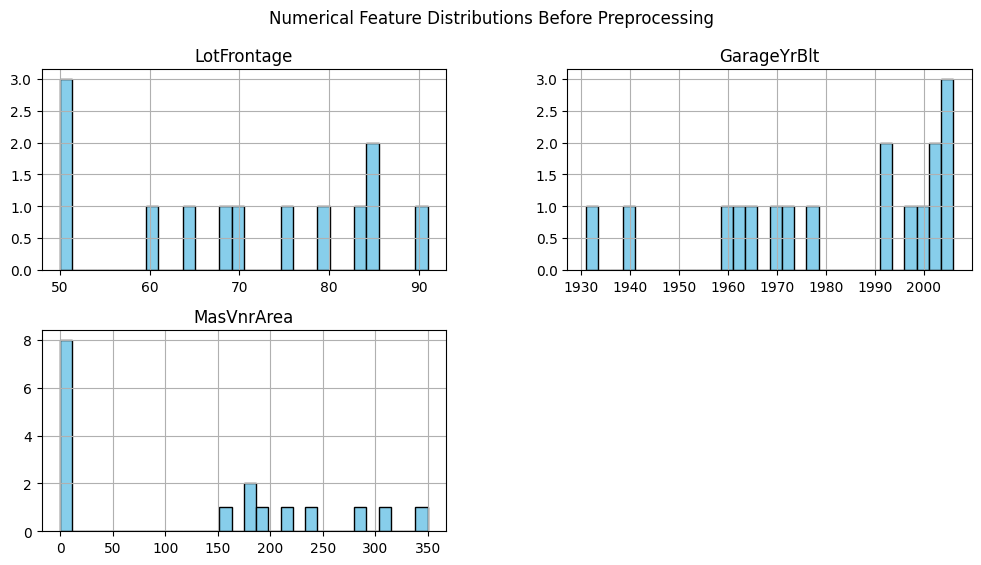

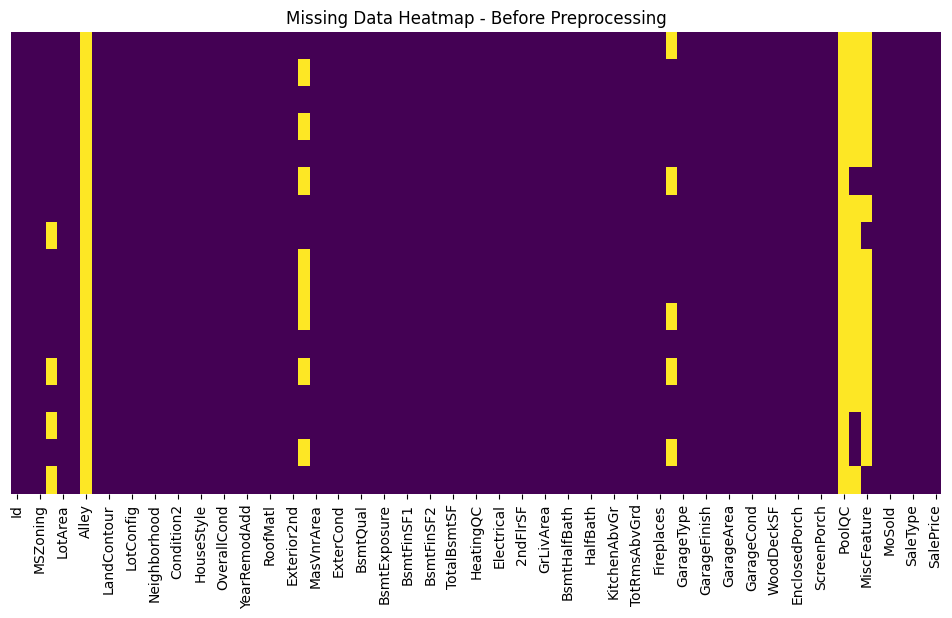

C:\Users\HP\AppData\Local\Temp\ipykernel_25704\3629190734.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna("None", inplace=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_25704\3629190734.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing

Total missing values after imputation: 0


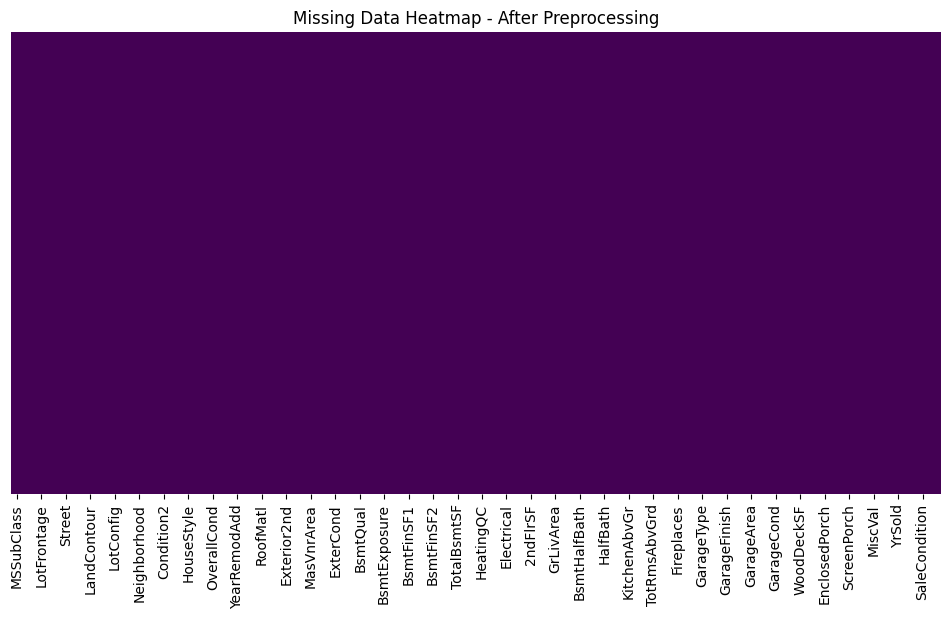

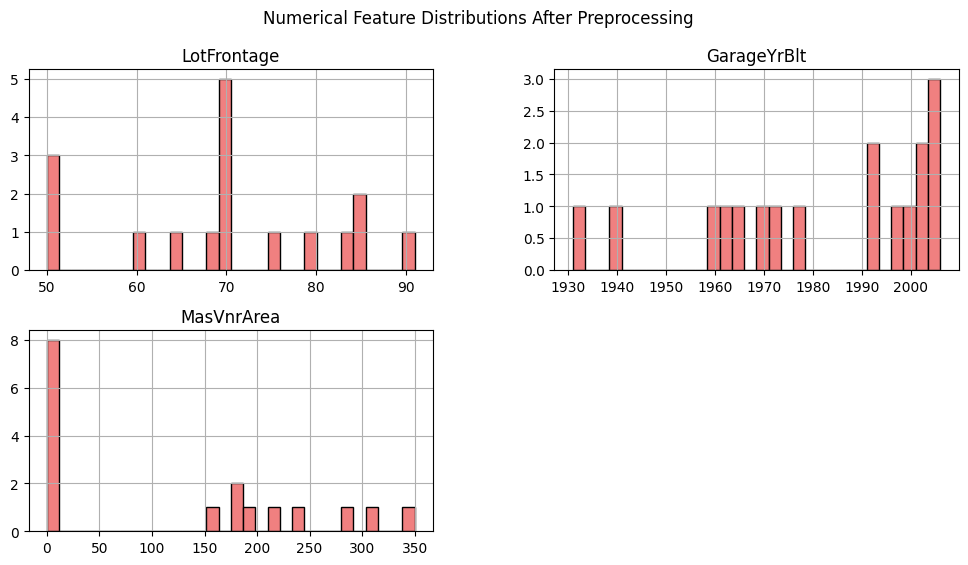

<Figure size 1200x600 with 0 Axes>

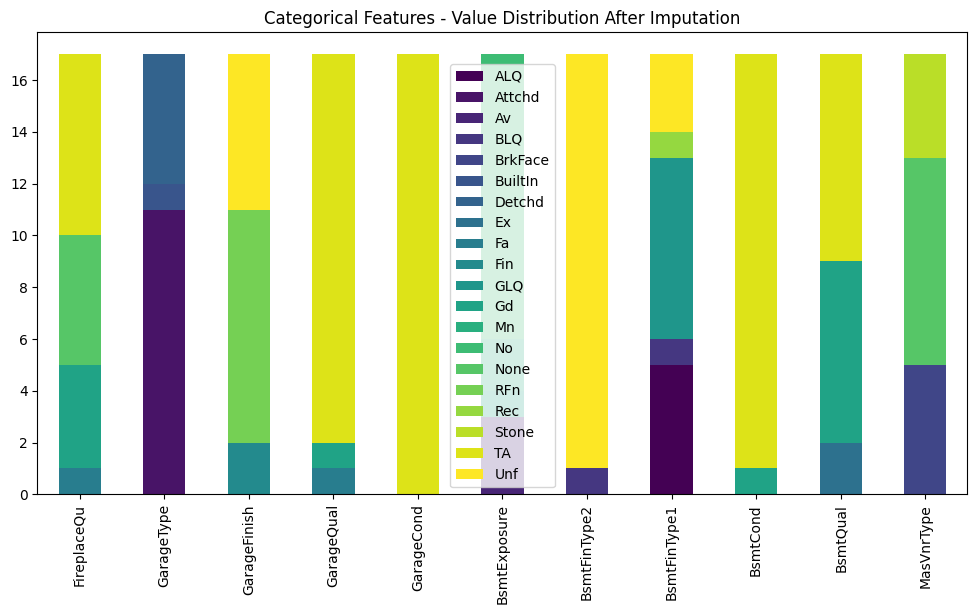

Dataset size after handling missing values: (17, 76)
Encoding complete. Data shape: (17, 98)
Standardization complete.
Processed data saved to: predict.csv


<Figure size 1500x1000 with 0 Axes>

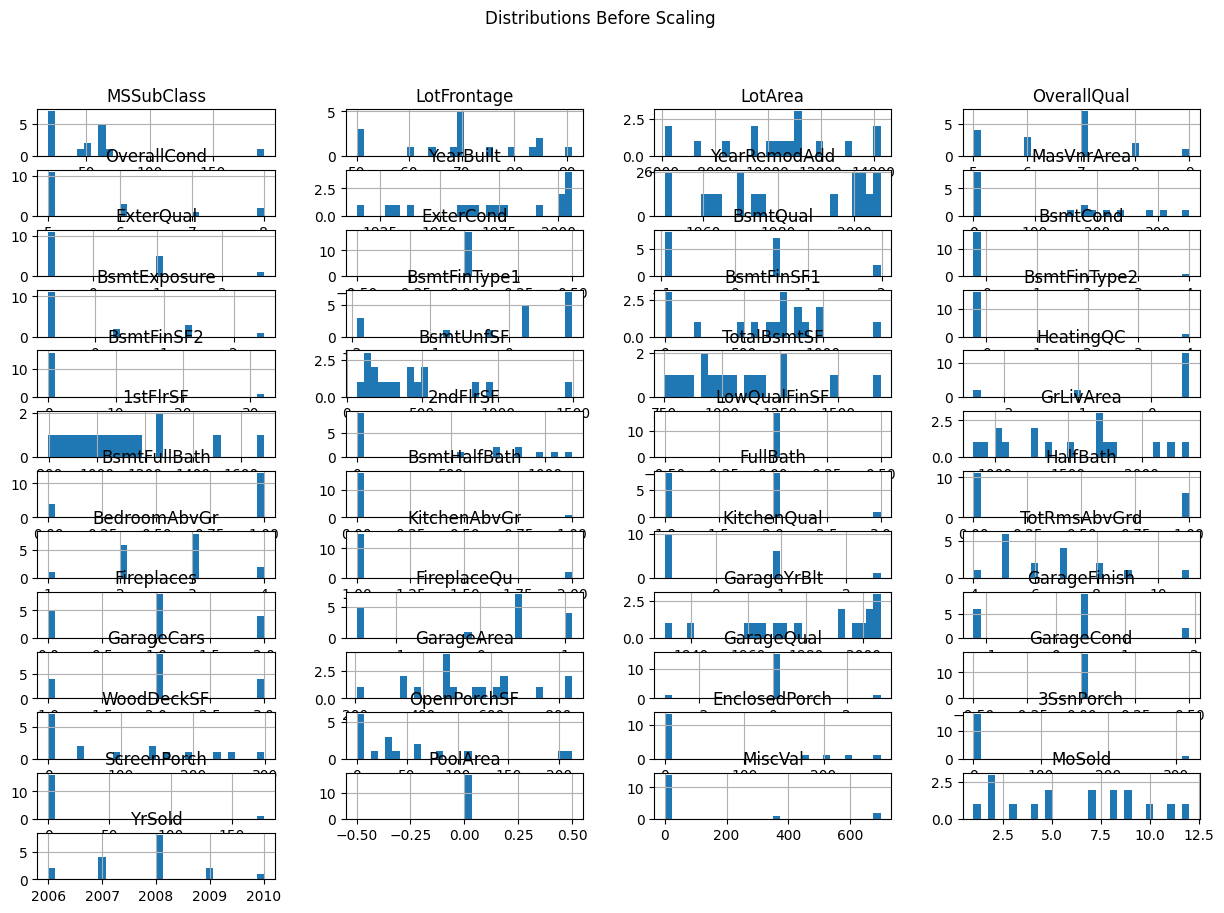

<Figure size 1500x1000 with 0 Axes>

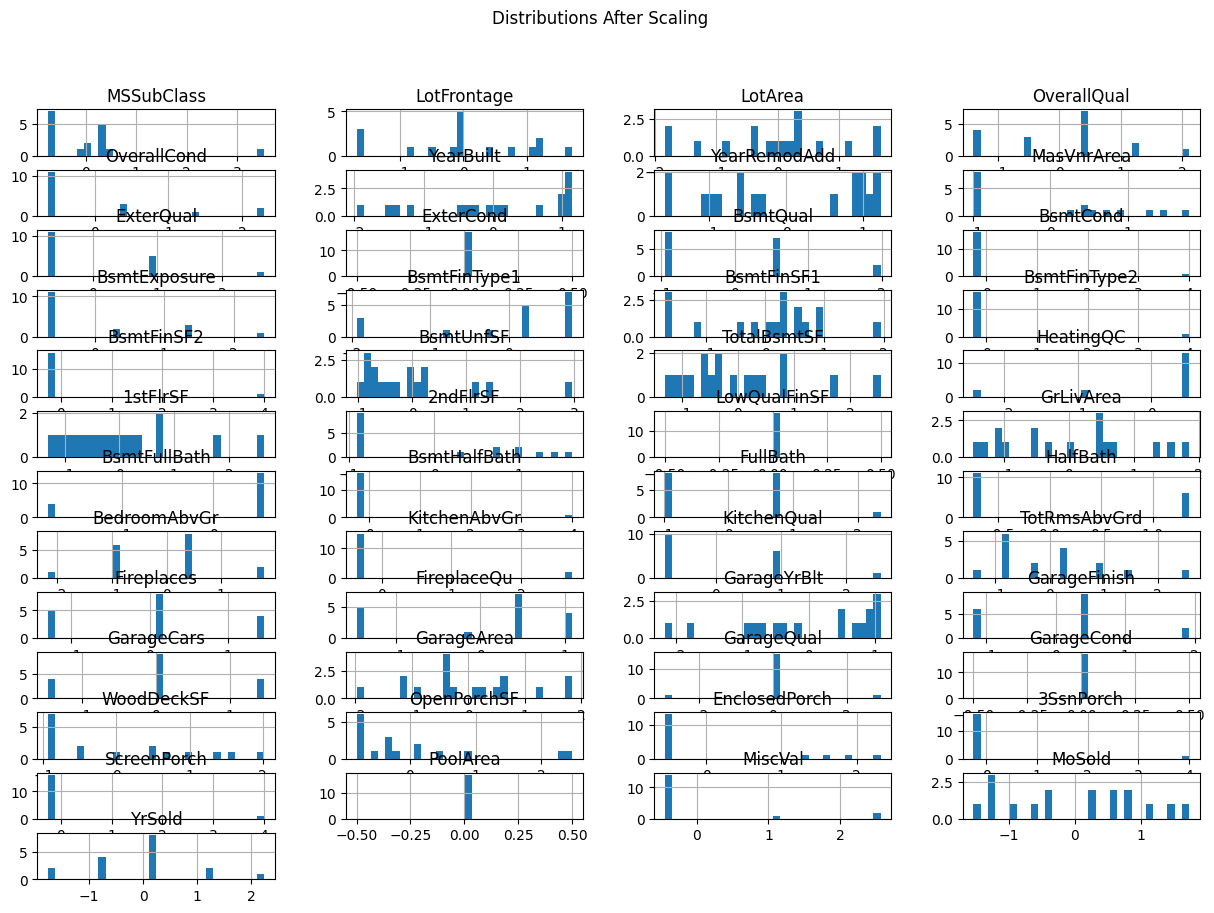

Scaling complete. Data saved to file.
📌 Selected 35 features based on correlation > 0.4
✅ Remaining data shape after removing NaNs: (17, 98)
✅ Selected 0 features after VIF filtering
❌ All features removed due to high VIF. Exiting...
✅ Preprocessing Completed. Data Shape: (17, 98)
🔄 Loading trained model...
✅ Model Loaded.
⚠️ Missing features in new data: {'GarageType_Attchd'}
⚠️ Extra features in new data: {'Condition1_PosN', 'ExterCond', 'BsmtFinSF2', 'BsmtUnfSF', 'HouseStyle_1.5Unf', 'MoSold', 'Exterior1st_HdBoard', 'HouseStyle_1Story', 'Condition1_Norm', 'WoodDeckSF', 'BsmtFullBath', 'BedroomAbvGr', 'SaleCondition_Partial', 'Neighborhood_Mitchel', 'BldgType_2fmCon', 'OverallCond', 'Neighborhood_NAmes', 'SaleType_WD', 'BsmtHalfBath', 'Exterior2nd_Wd Sdng', 'GarageQual', 'Neighborhood_OldTown', 'Electrical_FuseF', 'Exterior2nd_VinylSd', 'Exterior1st_VinylSd', 'GarageType_Detchd', 'Foundation_CBlock', 'Exterior1st_MetalSd', 'LotFrontage', 'BsmtCond', 'MasVnrType_Stone', 'Neighborhood_

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\stats\outliers_influence.py:197: 

array([185171.53621718, 153252.12202912, 200672.68258322, 168558.13605506,
       241521.25270139, 126676.79770108, 234883.1715406 , 193793.31254983,
       160823.04456958, 106235.39046579,  95144.81806065, 292406.80806902,
        79251.97602687, 217054.78234408, 117885.17665659, 120144.37058168,
       129674.05639559])

In [2183]:
def preprocess_and_predict(prediction_file, model_file):
    print("🔄 Starting Preprocessing...")

    # Step 1: Apply all preprocessing steps
    handleMissing(prediction_file)
    # removeOutliers(prediction_file)
    encode_and_standardize(prediction_file)
    scale_numerical_features(prediction_file)
    select_important_features(prediction_file)

    # Step 2: Load the processed dataset
    X_pred = pd.read_csv(prediction_file)
    print("✅ Preprocessing Completed. Data Shape:", X_pred.shape)

    # Step 3: Load the trained model
    print("🔄 Loading trained model...")
    model = joblib.load(model_file)
    print("✅ Model Loaded.")

    # Step 4: Check for feature consistency
    expected_features = model.feature_names_in_
    processed_features = X_pred.columns

    missing_from_data = set(expected_features) - set(processed_features)
    extra_in_data = set(processed_features) - set(expected_features)

    if missing_from_data:
        print(f"⚠️ Missing features in new data: {missing_from_data}")
    if extra_in_data:
        print(f"⚠️ Extra features in new data: {extra_in_data}")

    # Ensure features match the trained model
    X_pred = X_pred.reindex(columns=expected_features, fill_value=0)

    # Step 5: Predict house prices
    print("🔄 Running predictions...")
    predicted_prices = model.predict(X_pred)
    print("✅ Predictions Completed.")

    # Step 6: Print results in the required format
    print("📊 Predicted House Prices:")
    for i, price in enumerate(predicted_prices, 1):
        print(f"🏡 House {i}: ${price:,.2f}")

    return predicted_prices  # Return predictions if needed

# Example usage
preprocess_and_predict("predict.csv", "linearRegression.pkl")


In [2184]:
# from sklearn.preprocessing import PolynomialFeatures
# import joblib
# import pandas as pd
# import numpy as np

# def preprocess_and_predict(prediction_file, model_file, degree=None):
#     print("🔄 Starting Preprocessing...")

#     # Step 1: Apply all preprocessing steps
#     handleMissing(prediction_file)
#     # removeOutliers(prediction_file)
#     encode_and_standardize(prediction_file)
#     scale_numerical_features(prediction_file)
#     select_important_features(prediction_file)

#     # Step 2: Load the processed dataset
#     X_pred = pd.read_csv(prediction_file)
#     print("✅ Preprocessing Completed. Data Shape:", X_pred.shape)

#     # Step 3: Load the trained model
#     print("🔄 Loading trained model...")
#     model = joblib.load(model_file)
#     print("✅ Model Loaded.")

#     # Step 4: Check for feature consistency
#     expected_features = model.feature_names_in_ if hasattr(model, 'feature_names_in_') else X_pred.columns
#     processed_features = X_pred.columns

#     missing_from_data = set(expected_features) - set(processed_features)
#     extra_in_data = set(processed_features) - set(expected_features)

#     if missing_from_data:
#         print(f"⚠️ Missing features in new data: {missing_from_data}")
#     if extra_in_data:
#         print(f"⚠️ Extra features in new data: {extra_in_data}")

#     # Ensure features match the trained model
#     X_pred = X_pred.reindex(columns=expected_features, fill_value=0)

#     # Step 5: Polynomial feature transformation for polynomial regression
#     if degree is not None:
#         print(f"🔄 Applying Polynomial Feature Transformation (degree={degree})...")

#         # Only apply PolynomialFeatures to numeric columns
#         X_pred_numeric = X_pred.select_dtypes(include=['float64', 'int64'])

#         # If no numeric columns exist, exit
#         if X_pred_numeric.shape[1] == 0:
#             raise ValueError("No numeric features available for polynomial transformation.")

#         poly = PolynomialFeatures(degree=degree)
#         X_pred_poly = poly.fit_transform(X_pred_numeric)  # Apply to only numerical columns
#         print("✅ Polynomial Features Transformed.")

#         # Manually create feature names for the polynomial features
#         original_columns = X_pred_numeric.columns
#         poly_columns = poly.get_feature_names_out(input_features=original_columns)
#         X_pred_poly = pd.DataFrame(X_pred_poly, columns=poly_columns)

#         # Ensure the model's expected number of features is met
#         if X_pred_poly.shape[1] != model.n_features_in_:
#             print(f"⚠️ The transformed data has {X_pred_poly.shape[1]} features, "
#                   f"but the model expects {model.n_features_in_} features.")
#             # Align the features if needed
#             X_pred_poly = X_pred_poly.reindex(columns=model.feature_names_in_, fill_value=0)

#         predicted_prices = model.predict(X_pred_poly)
#     else:
#         # Use the model directly for linear regression
#         print("🔄 Running predictions with Linear Regression...")
#         predicted_prices = model.predict(X_pred)
#         print("✅ Predictions Completed.")

#     # Step 6: Print results in the required format
#     print("📊 Predicted House Prices:")
#     for i, price in enumerate(predicted_prices, 1):
#         print(f"🏡 House {i}: ${price:,.2f}")

#     return predicted_prices  # Return predictions if needed

# # Example usage for linear regression:
# preprocess_and_predict("predict.csv", "linearRegression.pkl")

# # Example usage for polynomial regression:
# # preprocess_and_predict("predict.csv", "polynomialRegression.pkl", degree=2)
